In [1]:
# Code started from https://matteoacrossi.github.io/oqs-jupyterbook/project_2-solution.html

import numpy as np
from scipy.optimize import fsolve, differential_evolution

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Tomography
#from qiskit.ignis.verification.tomography import state_tomography_circuits
#from qiskit.ignis.verification.tomography import StateTomographyFitter
# qiskit ignis is deprecated. Verification has been migrated to qiskit experiments
from qiskit_experiments.library import StateTomography
from qiskit_experiments.library.tomography import StateTomographyAnalysis

# Plots
import matplotlib.pyplot as plt

In [2]:
# We have an analytical solution of the system of equations
def theta_from_p(p):
    """ Returns the angles [theta_1, theta_2, theta_3] that implement the Pauli channel with
    probabilities p = [p_1, p_2, p_3]"""
    
    p = np.asarray(p, dtype=complex)
    c = [np.sqrt(1 - np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))/np.sqrt(2),
      np.sqrt(8*p[0]**3 - 4*p[0]**2*(-1 - 6*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) + 
           (1 - 2*p[2])**2*(-1 + 2*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) - 
           2*p[0]*(1 + 4*(p[2] - 3*p[2]**2 - p[2]*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))) + 
                 np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))))/
         (np.sqrt(2)*np.sqrt((-1 + 2*p[0] + 2*p[2])*(4*p[0]**2 + (1 - 2*p[2])**2 + p[0]*(4 + 8*p[2])))),
      np.sqrt((8*p[0]**3 - 4*p[0]**2*(-1 - 6*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) + 
             (1 - 2*p[2])**2*(-1 + 2*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) - 
             2*p[0]*(1 + 4*(p[2] - 3*p[2]**2 - p[2]*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))) + 
                   np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))))/
           (4*p[0]**2 + (1 - 2*p[2])**2 + p[0]*(4 + 8*p[2])))/np.sqrt(-2 + 4*p[0] + 4*p[2])]

    theta = 2*np.arccos(np.real(c))
    return theta

In [3]:
def pauli_channel(qc: QuantumCircuit, p: float, system: QuantumRegister, pauli_ancillae: list):
    """
        Apply the Pauli channel to system with probabilities p
        
    Args:
    q (QuantumCircuit): The quantum circuit to make a copy of and put the depolarizing channel onto.
    system (QuantumRegister): Register of the quantum circuit to use for the system.
    pauli_ancillae (list): List of QuantumRegisters to use for the ancillary qubits.
    p (list): list of probabilities [p_1, p_2, p_3] for the Pauli channel
    
    Returns:
    A QuantumCircuit implementing the Pauli channel
    """
    # Make a copy of the circuit passed in. This circuit will have the pauli depolarizing gates added to the end and then be returned.
    dc = qc.copy()

    # Calculate the values for the thetas based on the desired probabilites
    theta = theta_from_p(p)

    # Initialize the control ancillary qubits
    dc.ry(theta[0], pauli_ancillae[0])
    dc.cx(pauli_ancillae[0], pauli_ancillae[1])
    dc.ry(theta[1], pauli_ancillae[0])
    dc.ry(theta[2], pauli_ancillae[1])

    # Apply the pauli gates.
    dc.cx(pauli_ancillae[0], system)
    dc.cy(pauli_ancillae[1], system)

    return dc

In [4]:
from qiskit.quantum_info import entropy, partial_trace

def conditional_entropy(state, qubit_a, qubit_b):
    """Conditional entropy S(A|B) = S(AB) - S(B)
    
    Args:
        state: a vector or density operator
        qubit_a: 0-based index of the qubit A
        qubit_b: 0-based index of the qubit B
        
    Returns:
        int: the conditional entropy
    """
    return entropy(state) - entropy(partial_trace(state, [qubit_b]))

def extractable_work(state, system_qubit, memory_qubit, n=1):
    """Extractable work from a two-qubit state
    =
    Cfr. Eq. (3-4) Bylicka et al., Sci. Rep. 6, 27989 (2016)
    
    Args:
        qubit_a: 0-based index of the system qubit S
        qubit_b: 0-based index of the memory qubit M
    """
    return (n - conditional_entropy(state, system_qubit, memory_qubit)/np.log(2))

In [5]:
def p_enm(t, eta=1., omega=1.):
    p = [1/4 * (1 - np.exp(-2 * t *eta)), 
         1/4 * (1 - np.exp(-2 * t *eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 *np.exp(-t *eta) * np.cosh(t *omega))]
    return p

def p_ncp(t, eta=1., omega=1.):
    p = [1/4 * (1 - np.exp(-2 * t *eta)), 
         1/4 * (1 - np.exp(-2 * t *eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 *np.exp(-t *eta) * np.cos(t *omega))]
    return p

In [6]:
# Here are the parameters
t_values = np.linspace(0, 3, 11)

# Parameters
params_ncp = {'eta': 0.1, 'omega': 2.0}
params_enm = {'eta': 1.0, 'omega': .5}

# And the qubit assignments
SHOTS = 8192

q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

system = 2
ancilla = 4

pauli_ancillae = [0, 1]

In [7]:
# Prepare the two qubits 0 and 2 in a psi- state
prepare_two_qubit = QuantumCircuit(q)

prepare_two_qubit.x(q[ancilla])
prepare_two_qubit.x(q[system])
prepare_two_qubit.h(q[ancilla])
prepare_two_qubit.cx(q[ancilla], q[system]) 
prepare_two_qubit.barrier()

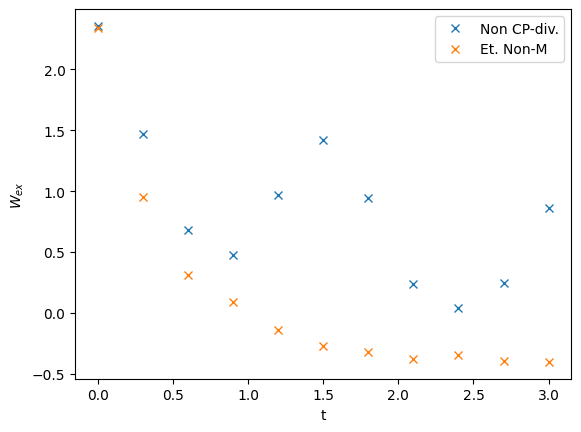

In [13]:
backend = Aer.get_backend('qasm_simulator')
fitter = 'linear_inversion'

wext_ncp = []

for t in t_values:
    circ =  pauli_channel(prepare_two_qubit, p_ncp(t, **params_ncp), system, [q[i] for i in pauli_ancillae])
    tomo_experiment = StateTomography(circ, measurement_indices=[system, ancilla])
    results = tomo_experiment.run(backend, fitter=fitter).block_for_results()
    rho = results.analysis_results("state").value.data
    wext_ncp.append(extractable_work(rho, 1, 0))

wext_enm = []

for t in t_values:
    circ =  pauli_channel(prepare_two_qubit, p_enm(t, **params_enm), system, [q[i] for i in pauli_ancillae])
    tomo_experiment = StateTomography(circ, measurement_indices=[system, ancilla])
    results = tomo_experiment.run(backend, fitter=fitter).block_for_results()
    rho = results.analysis_results("state").value.data
    wext_enm.append(extractable_work(rho, 1, 0))
    
plt.plot(t_values, wext_ncp, 'x', label='Non CP-div.')
plt.plot(t_values, wext_enm, 'x', label='Et. Non-M')
plt.legend()
plt.xlabel('t')
plt.ylabel('$W_{ex}$');